In [1]:
import os
import numpy as np
import xarray as xr
from IPython.display import display
from IPython.core.display import HTML
import glob
from pygments.formatters import HtmlFormatter
import zarr

import matplotlib.pyplot as plt
    

In [15]:
display(HTML("<h1 style='text-align:center;'>S3 OLCI L1 Product to zarr format</h1>"))

In [3]:

def get_ds(path_to_product,names=[]):

    nc_files = glob.glob(path_to_product + "/*.nc")
    
    variables = {}
    coordinates = {}

    for nc in nc_files:
        gname = os.path.basename(nc)[:-3]
        for name in names:
            if name == gname:
                ds = xr.open_dataset(nc,decode_times=False,mask_and_scale=False)
                for k in ds.variables.keys():
                    if 'coordinates' in gname:
                        coordinates[k] = ds.get(k)
                    else:
                        variables[k] = ds.get(k)
            
    ds = xr.Dataset(data_vars=variables,coords=coordinates)
    
    return ds


def s3_olci_l1_to_zarr(path_to_product,output_folder,mode="w"):
    product_name = os.path.basename(path_to_product)
    output_dir = os.path.join(output_folder,product_name)
    
    print("=== %s ===" % product_name)
   
    datasets = {}

    datasets['radiances'] = get_ds(path_to_product,["Oa%02d_radiance" %r for r in range(1,22)] + ["geo_coordinates","qualityFlags"])
    datasets['tie_points'] = get_ds(path_to_product,["tie_geo_coordinates","tie_meteo","tie_geometries"])
    datasets['removed_pixels'] = get_ds(path_to_product,["removed_pixels"])
    datasets['instrument_data'] = get_ds(path_to_product,["instrument_data"])

    for ds in datasets:
        datasets[ds].to_zarr("%s.zarr" % output_dir,mode=mode,group=ds)
        
    return datasets


In [4]:
# Get all S1 products samples
product = glob.glob("data/S3A_OL_1*.SEN3")[0]
print(product)

data/S3A_OL_1_EFR____20200101T101517_20200101T101817_20200102T141102_0179_053_179_2520_LN1_O_NT_002.SEN3


In [5]:
datasets = s3_olci_l1_to_zarr(product,"output","w")

=== S3A_OL_1_EFR____20200101T101517_20200101T101817_20200102T141102_0179_053_179_2520_LN1_O_NT_002.SEN3 ===


In [6]:
display(datasets['radiances'])

<xarray.Dataset>
Dimensions:        (rows: 4091, columns: 4865)
Coordinates:
    altitude       (rows, columns) int16 ...
    latitude       (rows, columns) int32 ...
    longitude      (rows, columns) int32 ...
Dimensions without coordinates: rows, columns
Data variables: (12/22)
    Oa18_radiance  (rows, columns) uint16 ...
    Oa21_radiance  (rows, columns) uint16 ...
    Oa05_radiance  (rows, columns) uint16 ...
    Oa19_radiance  (rows, columns) uint16 ...
    Oa20_radiance  (rows, columns) uint16 ...
    Oa04_radiance  (rows, columns) uint16 ...
    ...             ...
    Oa01_radiance  (rows, columns) uint16 ...
    Oa10_radiance  (rows, columns) uint16 ...
    Oa13_radiance  (rows, columns) uint16 ...
    Oa17_radiance  (rows, columns) uint16 ...
    quality_flags  (rows, columns) uint32 ...
    Oa03_radiance  (rows, columns) uint16 ...

**====> Reading OLCI L1 zarr format**

In [8]:
product_path = "output/" + os.path.basename(product) + ".zarr"
z = zarr.open(product_path,mode="r")
z.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='instrument_data', nodes=(Node(disab…

In [9]:
product_name = os.path.basename(product) + ".zarr"
ds = xr.open_zarr('%s/radiances' % product_path,consolidated=False)

In [10]:
display(ds)

<xarray.Dataset>
Dimensions:        (rows: 4091, columns: 4865)
Coordinates:
    altitude       (rows, columns) float32 dask.array<chunksize=(512, 609), meta=np.ndarray>
    latitude       (rows, columns) float64 dask.array<chunksize=(512, 609), meta=np.ndarray>
    longitude      (rows, columns) float64 dask.array<chunksize=(512, 609), meta=np.ndarray>
Dimensions without coordinates: rows, columns
Data variables: (12/22)
    Oa01_radiance  (rows, columns) float32 dask.array<chunksize=(512, 609), meta=np.ndarray>
    Oa02_radiance  (rows, columns) float32 dask.array<chunksize=(512, 609), meta=np.ndarray>
    Oa03_radiance  (rows, columns) float32 dask.array<chunksize=(512, 609), meta=np.ndarray>
    Oa04_radiance  (rows, columns) float32 dask.array<chunksize=(512, 609), meta=np.ndarray>
    Oa05_radiance  (rows, columns) float32 dask.array<chunksize=(512, 609), meta=np.ndarray>
    Oa06_radiance  (rows, columns) float32 dask.array<chunksize=(512, 609), meta=np.ndarray>
    ...             ...
    Oa17_radiance  (rows, columns) float32 dask.array<chunksize=(512, 609), meta=np.ndarray>
    Oa18_radiance  (rows, columns) float32 dask.array<chunksize=(512, 609), meta=np.ndarray>
    Oa19_radiance  (rows, columns) float32 dask.array<chunksize=(512, 609), meta=np.ndarray>
    Oa20_radiance  (rows, columns) float32 dask.array<chunksize=(512, 609), meta=np.ndarray>
    Oa21_radiance  (rows, columns) float32 dask.array<chunksize=(512, 609), meta=np.ndarray>
    quality_flags  (rows, columns) uint32 dask.array<chunksize=(512, 609), meta=np.ndarray>

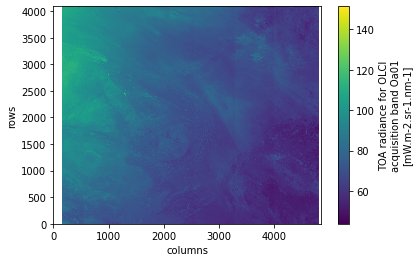

In [11]:
ds.Oa01_radiance.plot()
plt.show()

**Region of interest**

In [17]:
d=ds.where((ds.latitude> 20) & (ds.latitude < 25) & (ds.longitude >-2) & (ds.longitude < 2),drop=True )
display(d)

<xarray.Dataset>
Dimensions:        (rows: 2149, columns: 1942)
Coordinates:
    altitude       (rows, columns) float32 dask.array<chunksize=(356, 122), meta=np.ndarray>
    latitude       (rows, columns) float64 dask.array<chunksize=(356, 122), meta=np.ndarray>
    longitude      (rows, columns) float64 dask.array<chunksize=(356, 122), meta=np.ndarray>
Dimensions without coordinates: rows, columns
Data variables: (12/22)
    Oa01_radiance  (rows, columns) float32 dask.array<chunksize=(356, 122), meta=np.ndarray>
    Oa02_radiance  (rows, columns) float32 dask.array<chunksize=(356, 122), meta=np.ndarray>
    Oa03_radiance  (rows, columns) float32 dask.array<chunksize=(356, 122), meta=np.ndarray>
    Oa04_radiance  (rows, columns) float32 dask.array<chunksize=(356, 122), meta=np.ndarray>
    Oa05_radiance  (rows, columns) float32 dask.array<chunksize=(356, 122), meta=np.ndarray>
    Oa06_radiance  (rows, columns) float32 dask.array<chunksize=(356, 122), meta=np.ndarray>
    ...             ...
    Oa17_radiance  (rows, columns) float32 dask.array<chunksize=(356, 122), meta=np.ndarray>
    Oa18_radiance  (rows, columns) float32 dask.array<chunksize=(356, 122), meta=np.ndarray>
    Oa19_radiance  (rows, columns) float32 dask.array<chunksize=(356, 122), meta=np.ndarray>
    Oa20_radiance  (rows, columns) float32 dask.array<chunksize=(356, 122), meta=np.ndarray>
    Oa21_radiance  (rows, columns) float32 dask.array<chunksize=(356, 122), meta=np.ndarray>
    quality_flags  (rows, columns) float64 dask.array<chunksize=(356, 122), meta=np.ndarray>

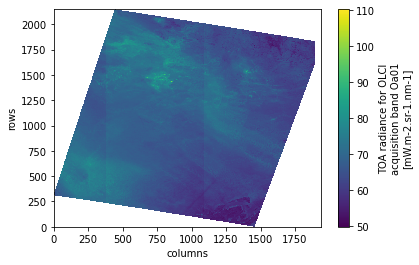

In [18]:
d.Oa01_radiance.plot()
plt.show()

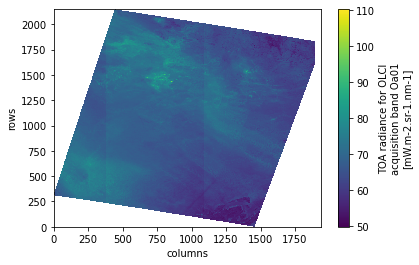

In [14]:
d.Oa01_radiance.plot()
plt.show()
